In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
from scipy.interpolate import griddata

# Preprocessing Data (Filter out unwanted columns and combining symptons into a list in merged_symptons)
CSV_Data = './2021VAERSDATA.csv'
CSV_Symptoms = './2021VAERSSYMPTOMS.csv'
CSV_Vax = "./2021VAERSVAX.csv" 

df_d = pd.read_csv(CSV_Data, names = ['VAERS_ID','RECVDATE','STATE','AGE_YRS','CAGE_YR','CAGE_MO','SEX','RPT_DATE','SYMPTOM_TEXT','DIED','DATEDIED','L_THREAT','ER_VISIT','HOSPITAL','HOSPDAYS','X_STAY','DISABLE','RECOVD','VAX_DATE','ONSET_DATE','NUMDAYS','LAB_DATA','V_ADMINBY','V_FUNDBY','OTHER_MEDS','CUR_ILL','HISTORY','PRIOR_VAX','SPLTTYPE','FORM_VERS','TODAYS_DATE','BIRTH_DEFECT','OFC_VISIT','ER_ED_VISIT','ALLERGIES'],error_bad_lines=False, index_col=False, dtype='unicode')
df = df_d.drop(['CAGE_YR','STATE', 'CAGE_MO', 'DIED','RPT_DATE','SYMPTOM_TEXT','DATEDIED','L_THREAT','ER_VISIT','HOSPITAL','HOSPDAYS','X_STAY','DISABLE','RECOVD','VAX_DATE','ONSET_DATE','NUMDAYS','LAB_DATA','V_ADMINBY','V_FUNDBY','OTHER_MEDS','SPLTTYPE','FORM_VERS','TODAYS_DATE','BIRTH_DEFECT','OFC_VISIT','ER_ED_VISIT'], axis=1)
df_s = pd.read_csv(CSV_Symptoms, names = ['VAERS_ID','SYMPTOM1','SYMPTOMVERSION1','SYMPTOM2','SYMPTOMVERSION2','SYMPTOM3','SYMPTOMVERSION3','SYMPTOM4','SYMPTOMVERSION4','SYMPTOM5','SYMPTOMVERSION5'],error_bad_lines=False, index_col=False, dtype='unicode')
df_s = df_s.drop(['SYMPTOMVERSION1','SYMPTOMVERSION2','SYMPTOMVERSION3','SYMPTOMVERSION4','SYMPTOMVERSION5'], axis = 1)
df_s['MERGED_SYMPTONS'] = df_s[df_s.columns[1:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)
df_s = df_s.drop(['VAERS_ID','SYMPTOM1','SYMPTOM2','SYMPTOM3','SYMPTOM4','SYMPTOM5'], axis = 1)
df = pd.concat([df,df_s], axis=1, join="inner")
df_v = pd.read_csv (CSV_Vax, names = ['VAERS_ID','VAX_TYPE','VAX_MANU','VAX_LOT','VAX_DOSE_SERIES','VAX_ROUTE','VAX_SITE','VAX_NAME'],error_bad_lines=False, index_col=False, dtype='unicode')
df_v = df_v.drop(['VAERS_ID','VAX_TYPE','VAX_LOT','VAX_ROUTE','VAX_SITE','VAX_NAME'], axis = 1)
df = pd.concat([df,df_v], axis=1, join="inner")

df = df.drop (df.index[0])
# Get symptons from age, sex, vac manu, vax dose series
df_as = df.drop(['RECVDATE','CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'ALLERGIES'], axis = 1)
df_as

VAERS_ID AGE_YRS SEX  \
1       0916600    33.0   F   
2       0916601    73.0   F   
3       0916602    23.0   F   
4       0916603    58.0   F   
5       0916604    47.0   F   
...         ...     ...  ..   
146618  1272609    71.0   M   
146619  1272610    41.0   F   
146620  1272636    24.0   F   
146621  1272661    87.0   F   
146622  1272683    24.0   M   

                                          MERGED_SYMPTONS         VAX_MANU  \
1                                  Dysphagia,Epiglottitis          MODERNA   
2                                        Anxiety,Dyspnoea          MODERNA   
3       Chest discomfort,Dysphagia,Pain in extremity,V...  PFIZER\BIONTECH   
4                    Dizziness,Fatigue,Mobility decreased          MODERNA   
5       Injection site erythema,Injection site pruritu...          MODERNA   
...                                                   ...              ...   
146618  Blood glucose increased,Fatigue,Headache,Type ...  PFIZER\BIONTECH   
146619                 Injection site reaction,Thrombosis  PFIZER\BIONTECH   
146620                                              Death  PFIZER\BIONTECH   
146621            Chest pain,Cough,Rash,Rash erythematous  PFIZER\BIONTECH   
146622  Anaphylactic reaction,Dizziness,Nausea,Pruritu...  PFIZER\BIONTECH   

       VAX_DOSE_SERIES  
1                    1  
2                    1  
3                    1  
4                  UNK  
5                    1  
...                ...  
146618               2  
146619               1  
146620               2  
146621               1  
146622               1  

[146622 rows x 6 columns]

In [2]:
df_as.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 146622 entries, 1 to 146622
Data columns (total 6 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   VAERS_ID         146622 non-null  object
 1   AGE_YRS          131782 non-null  object
 2   SEX              146622 non-null  object
 3   MERGED_SYMPTONS  146622 non-null  object
 4   VAX_MANU         146622 non-null  object
 5   VAX_DOSE_SERIES  145639 non-null  object
dtypes: object(6)
memory usage: 7.8+ MB


In [3]:
# Get symptoms occurrences 

SYMPTOM_Dict ={}
num = 0
for x in df_as['MERGED_SYMPTONS']:
    string = ""
    for char in x:
        if(char == ","):
            if string in SYMPTOM_Dict :
                SYMPTOM_Dict[string] += 1
            else :
                SYMPTOM_Dict[string] = 1
            
            string = ""
        else:
            string += char
    if string in SYMPTOM_Dict :
        SYMPTOM_Dict[string] += 1
    else :
        SYMPTOM_Dict[string] = 1
    
sorted_dict = {}
sorted_keys = sorted(SYMPTOM_Dict, key=SYMPTOM_Dict.get, reverse = True)

for x in sorted_keys:
    sorted_dict[x] = SYMPTOM_Dict[x]

for x in sorted_dict:
    print(x,":",sorted_dict[x])


Headache : 24910
Chills : 20248
Pyrexia : 20152
Fatigue : 18756
Pain : 18481
Nausea : 13776
Dizziness : 11546
Pain in extremity : 10846
Injection site pain : 10387
Injection site erythema : 9595
Myalgia : 8398
Arthralgia : 7354
Injection site swelling : 7084
Pruritus : 6872
Injection site pruritus : 6628
Rash : 6041
Dyspnoea : 5324
Erythema : 5256
Injection site warmth : 5001
Vomiting : 4800
Asthenia : 4435
Diarrhoea : 3992
Urticaria : 3987
Paraesthesia : 3938
Lymphadenopathy : 3894
Malaise : 3635
Hyperhidrosis : 3361
Hypoaesthesia : 3253
Injection site rash : 3194
Feeling abnormal : 2867
Cough : 2590
Peripheral swelling : 2566
Chest discomfort : 2465
Heart rate increased : 2391
Skin warm : 2368
Tremor : 2276
Body temperature increased : 2209
Flushing : 2182
Feeling hot : 2160
Palpitations : 2106
Swelling : 2070
SARS-CoV-2 test negative : 2069
Rash erythematous : 2050
Chest pain : 2042
Back pain : 1990
SARS-CoV-2 test positive : 1937
Decreased appetite : 1879
Neck pain : 1863
Paraesthe

Alopecia : 40
Troponin I normal : 40
Stress : 40
Hypoglycaemia : 40
Chronic obstructive pulmonary disease : 40
Pulseless electrical activity : 40
Mouth ulceration : 39
Liver function test increased : 39
Orthostatic hypotension : 39
Troponin I : 39
Injection site hypersensitivity : 39
Vaccination site movement impairment : 39
Lymphocyte count decreased : 39
Eosinophil percentage : 39
X-ray limb : 39
Rheumatoid arthritis : 39
Electroencephalogram normal : 39
Eczema : 38
Ultrasound abdomen : 38
Pharyngeal erythema : 38
Dementia : 38
Anion gap : 38
Frequent bowel movements : 38
Faeces discoloured : 38
Panic reaction : 38
Ischaemic stroke : 38
Oral mucosal blistering : 37
Bursitis : 37
Haematuria : 37
Gingival swelling : 37
Stridor : 37
Sinus operation : 37
Gastrointestinal haemorrhage : 37
Hyponatraemia : 37
Pregnancy : 37
Monoplegia : 37
Staring : 37
Bilevel positive airway pressure : 37
Vomiting projectile : 36
Tension : 36
Injection site infection : 36
Face oedema : 36
Photosensitivity 

Skin weeping : 15
HIV test negative : 15
Mononucleosis heterophile test negative : 15
Treponema test negative : 15
Vitamin B12 : 15
Tearfulness : 15
Tongue eruption : 15
Laparoscopic surgery : 15
Catheterisation cardiac abnormal : 15
Muscle disorder : 15
Sputum discoloured : 15
Gastritis : 15
Respiratory rate : 15
Angiogram abnormal : 15
Disorganised speech : 15
Lip injury : 15
Hiccups : 15
Transient global amnesia : 15
Acute respiratory distress syndrome : 15
Intervertebral disc protrusion : 15
Blood electrolytes : 15
Albumin globulin ratio normal : 15
Blood creatine phosphokinase MB : 15
Vaccination site discharge : 15
Blood pH decreased : 15
Blood urine absent : 15
Vaccination error : 15
Blood pressure systolic increased : 14
Lung consolidation : 14
Postictal state : 14
Angiogram pulmonary normal : 14
Psychomotor hyperactivity : 14
Palatal swelling : 14
Mastitis : 14
Cardiac assistance device user : 14
Myocardial necrosis marker increased : 14
Vasculitis : 14
Eye inflammation : 14
B

Rhonchi : 7
Uveitis : 7
Tonic clonic movements : 7
Neck injury : 7
Vaccination site joint movement impairment : 7
Oxygen saturation abnormal : 7
Serum ferritin normal : 7
Sinus arrhythmia : 7
Vulvovaginal pruritus : 7
CSF glucose normal : 7
Muscle spasticity : 7
Adverse drug reaction : 7
Cytokine storm : 7
Increased insulin requirement : 7
Physical examination abnormal : 7
Contraindication to vaccination : 7
Coronary artery stenosis : 7
Lung neoplasm malignant : 7
Critical illness : 7
Thyroxine free normal : 7
Scan normal : 7
Mammogram normal : 7
Breast feeding : 7
Epigastric discomfort : 7
Eye infection : 7
Eyelid irritation : 7
Blood calcium increased : 7
Blood immunoglobulin G decreased : 7
Hypercalcaemia : 7
Specialist consultation : 7
Blepharitis : 7
Rectal tenesmus : 7
Intraocular pressure test : 7
Partial seizures : 7
Goitre : 7
Muscle strength abnormal : 7
Injection site injury : 7
Multiple sclerosis relapse : 7
Borrelia test : 7
Grunting : 7
Coronavirus test : 7
Staphylococcus

Blood phosphorus increased : 4
Wound secretion : 4
Brachial plexopathy : 4
Neoplasm malignant : 4
Varicella post vaccine : 4
Hepatic steatosis : 4
Chronic respiratory failure : 4
Thyroxine free increased : 4
Carpal tunnel syndrome : 4
Cerebral congestion : 4
Perfusion brain scan normal : 4
Impaired self-care : 4
Respiratory tract oedema : 4
Basophil count : 4
Human chorionic gonadotropin positive : 4
Basal ganglia infarction : 4
Blood immunoglobulin A : 4
Change of bowel habit : 4
Bone swelling : 4
Colonoscopy abnormal : 4
Haemoperitoneum : 4
Demyelination : 4
Protein S : 4
Urinary system X-ray : 4
Epstein-Barr virus test negative : 4
Blood urine : 4
Nerve conduction studies abnormal : 4
Oesophagogastroduodenoscopy normal : 4
Haemophagocytic lymphohistiocytosis : 4
Pharyngeal inflammation : 4
Fungal test negative : 4
Clostridium test negative : 4
Immunosuppression : 4
Vulvovaginal rash : 4
Tooth fracture : 4
Carotid artery stenosis : 4
Patient isolation : 4
Influenza A virus test posit

Cyst removal : 2
Scleral haemorrhage : 2
Bronchial secretion retention : 2
Eyelid skin dryness : 2
Neuromuscular pain : 2
Hypochromic anaemia : 2
Oedema mucosal : 2
Sinonasal obstruction : 2
Panniculitis : 2
Cerebral palsy : 2
Vulvovaginal pain : 2
Orbital swelling : 2
Administration site bruise : 2
Bone disorder : 2
Chalazion : 2
Vaccination site papule : 2
Crystal urine present : 2
Bladder discomfort : 2
Pre-existing condition improved : 2
Human rhinovirus test : 2
Progesterone : 2
Blast cells present : 2
Smear cervix : 2
Scleral oedema : 2
Chiropractic : 2
Contraindicated product administered : 2
Light chain analysis increased : 2
Parathyroid hormone-related protein increased : 2
Breast cellulitis : 2
Blood pressure orthostatic : 2
Hepatitis C : 2
Lymphadenectomy : 2
Cutaneous vasculitis : 2
Trichoglossia : 2
Mast cell activation syndrome : 2
Injection site erosion : 2
Genital herpes simplex : 2
Tissue irritation : 2
Skin striae : 2
Skin wrinkling : 2
Allergy to surgical sutures : 2

Endometriosis : 1
Genital hypoaesthesia : 1
Rhinoscopy : 1
Mucosal erosion : 1
Blood pressure orthostatic normal : 1
Heart sounds abnormal : 1
Vaccination site hyperaesthesia : 1
Blood pressure diastolic decreased : 1
25-dihydroxycholecalciferol : 1
Electrophoresis protein abnormal : 1
Parathyroid hormone-related protein : 1
Allen's test : 1
Base excess decreased : 1
Laryngoscopy abnormal : 1
Pulmonary imaging procedure abnormal : 1
Cough variant asthma : 1
Ophthalmoplegic migraine : 1
Adjusted calcium increased : 1
Lipoedema : 1
Malignant nipple neoplasm female : 1
Renal artery stenosis : 1
Keloid scar : 1
Hypertrophy : 1
Vaccination site abscess : 1
Trigeminal neuritis : 1
Nerve block : 1
Microembolism : 1
Eczema eyelids : 1
Vascular resistance systemic increased : 1
Intracerebral haematoma evacuation : 1
Oral dysaesthesia : 1
Uterine contractions abnormal : 1
Cardiac ventriculogram left : 1
Tinea capitis : 1
Surgical procedure repeated : 1
Exostosis : 1
Electrocardiogram ST segment 

Transferrin increased : 1
Abortion spontaneous incomplete : 1
Analgesic drug level decreased : 1
Poisoning : 1
Sulphur dioxide test : 1
Saliva analysis : 1
Metamyelocyte count increased : 1
Anogenital warts : 1
Vitamin C increased : 1
Optometric therapy : 1
Polydactyly : 1
Rebound effect : 1
Alpha 1 foetoprotein normal : 1
Mean cell haemoglobin concentration increased : 1
Vascular malformation : 1
Pleural thickening : 1
Tonsillar disorder : 1
Anembryonic gestation : 1
Smear cervix abnormal : 1
Choroidal detachment : 1
Cystoid macular oedema : 1
Fundus autofluorescence : 1
Ultrasound eye abnormal : 1
Multifocal micronodular pneumocyte hyperplasia : 1
Feeling of relaxation : 1
Plastic surgery to the face : 1
Diverticulitis intestinal perforated : 1
Cerebral microhaemorrhage : 1
Choreoathetosis : 1
Positron emission tomogram abnormal : 1
Faecal vomiting : 1
Anhedonia : 1
Pericardial cyst : 1
Anal skin tags : 1
Nasal odour : 1
Lacrimation decreased : 1
Helicobacter test : 1
Staphylococcus 

New daily persistent headache : 1
Klebsiella test positive : 1
Bacterial vaginosis : 1
Tissue infiltration : 1
Somatic symptom disorder : 1
Papillitis : 1
Blood ketone body absent : 1
Urine bilirubin decreased : 1
Cervix inflammation : 1
Hypocomplementaemia : 1
Interleukin-2 receptor assay : 1
Total complement activity decreased : 1
Venous thrombosis limb : 1
Foetal distress syndrome : 1
Rheumatoid factor increased : 1
Pharyngeal abscess : 1
Umbilical cord abnormality : 1
Glomerulonephritis : 1
Blood electrolytes abnormal : 1
Throat lesion : 1
Walking distance test : 1
Gastrointestinal tract irritation : 1
Central pain syndrome : 1
Oesophageal rupture : 1
Allergic sinusitis : 1
CSF monocyte count increased : 1
CSF white blood cell count positive : 1
Blood bilirubin unconjugated decreased : 1
Lymphoproliferative disorder : 1
Allergic bronchitis : 1
Dermatomyositis : 1
Enteral nutrition : 1
Arachnoiditis : 1
Band neutrophil count increased : 1
Blast cells : 1
Lymphocyte morphology abnorm

In [4]:
# add symptoms column to dataframe

symtoms = ["Headache","Chills","Pyrexia","Fatigue","Nausea","Dizziness","Injection site pain","Arthralgia","Pruritus","Rash","Dyspnoea","Erythema","Vomiting"]

for symtom in symtoms:
    l = []
    num = 0
    for x in df_as['MERGED_SYMPTONS']:
        string = ""
        check_contain = False
        for char in x:
            if(char == ","):
                if string == symtom:
                    check_contain = True
                string = ""
            else:
                string += char
        if string == symtom:
            check_contain = True
        num += 1
        if (check_contain):
            l.append(1)
        else:
            l.append(0)
    df_as.insert(len(df_as.columns),symtom,l,True)

df_asn = df_as.drop(["MERGED_SYMPTONS"],axis = 1)

In [7]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# Remove rows where VAX_DOSE_SERIES is not 1 or 2
df_asn.drop(df_asn[(df_asn['VAX_DOSE_SERIES']!="1") & (df_asn['VAX_DOSE_SERIES']!="2")].index, inplace = True)
# Remove rows where VZX_MANU is not Moderna, Pfizer\Biotech, or Janssen
df_asn.drop(df_asn[(df_asn['VAX_MANU']!="MODERNA") & (df_asn['VAX_MANU']!="PFIZER\BIONTECH") &(df_asn['VAX_MANU']!="JANSSEN")].index, inplace = True)
# ID_encoded = le.fit_transform(np.ravel(df_as["VAERS_ID"]))
df_asn["VAERS_ID"] = df_asn["VAERS_ID"].astype(str).astype(int)
# Remove rows where Age is missing
df_asn.drop(df_asn[df_asn['AGE_YRS'].isna()].index, inplace = True)
df_asn["AGE_YRS"] = df_asn["AGE_YRS"].astype(str).astype(float)
Sex_encoded = le.fit_transform(np.ravel(df_asn["SEX"]))
df_asn["SEX"] = Sex_encoded
# 0 = JANSSEN, 1 = MODERNA, 2 = PFIZER\BIONTECH
VAX_MANU_encoded = le.fit_transform(np.ravel(df_asn["VAX_MANU"]))
df_asn["VAX_MANU"] = VAX_MANU_encoded
df_asn["VAX_DOSE_SERIES"] = df_asn["VAX_DOSE_SERIES"].astype(str).astype(int)

df_asn

VAERS_ID  AGE_YRS  SEX  VAX_MANU  VAX_DOSE_SERIES  Headache  Chills  \
1         916600     33.0    0         1                1         0       0   
2         916601     73.0    0         1                1         0       0   
3         916602     23.0    0         2                1         0       0   
5         916604     47.0    0         1                1         0       0   
6         916606     44.0    0         1                1         0       0   
...          ...      ...  ...       ...              ...       ...     ...   
146618   1272609     71.0    1         2                2         1       0   
146619   1272610     41.0    0         2                1         0       0   
146620   1272636     24.0    0         2                2         0       0   
146621   1272661     87.0    0         2                1         0       0   
146622   1272683     24.0    1         2                1         0       0   

        Pyrexia  Fatigue  Nausea  Dizziness  Injection site pain  Arthralgia  \
1             0        0       0          0                    0           0   
2             0        0       0          0                    0           0   
3             0        0       0          0                    0           0   
5             0        0       0          0                    0           0   
6             0        0       0          0                    0           0   
...         ...      ...     ...        ...                  ...         ...   
146618        0        1       0          0                    0           0   
146619        0        0       0          0                    0           0   
146620        0        0       0          0                    0           0   
146621        0        0       0          0                    0           0   
146622        0        0       1          1                    0           0   

        Pruritus  Rash  Dyspnoea  Erythema  Vomiting  
1              0     0         0         0         0  
2              0     0         1         0         0  
3              0     0         0         0         0  
5              0     0         0         0         0  
6              0     0         0         0         0  
...          ...   ...       ...       ...       ...  
146618         0     0         0         0         0  
146619         0     0         0         0         0  
146620         0     0         0         0         0  
146621         0     1         0         0         0  
146622         1     0         0         0         0  

[106713 rows x 18 columns]

In [8]:
df_asn.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106713 entries, 1 to 146622
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   VAERS_ID             106713 non-null  int64  
 1   AGE_YRS              106713 non-null  float64
 2   SEX                  106713 non-null  int64  
 3   VAX_MANU             106713 non-null  int64  
 4   VAX_DOSE_SERIES      106713 non-null  int64  
 5   Headache             106713 non-null  int64  
 6   Chills               106713 non-null  int64  
 7   Pyrexia              106713 non-null  int64  
 8   Fatigue              106713 non-null  int64  
 9   Nausea               106713 non-null  int64  
 10  Dizziness            106713 non-null  int64  
 11  Injection site pain  106713 non-null  int64  
 12  Arthralgia           106713 non-null  int64  
 13  Pruritus             106713 non-null  int64  
 14  Rash                 106713 non-null  int64  
 15  Dyspnoea         

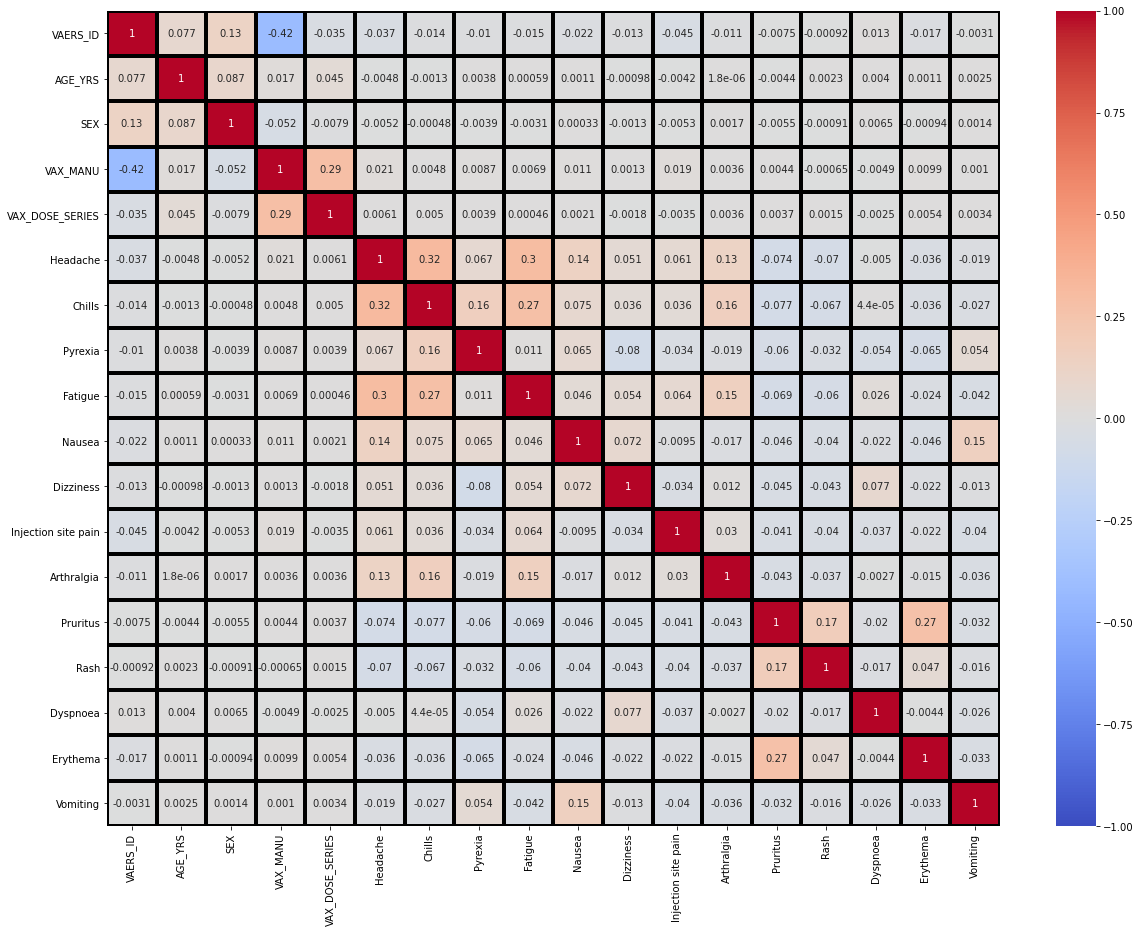

In [9]:
import seaborn as sns
import numpy as np
fig, ax = plt.subplots(figsize=(20,15))  
sns.heatmap(df_asn.corr(), annot = True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', linewidths=3, linecolor='black')
plt.show()

AGE_YRS: 71.0
SEX: 0
VAX_MANU: 1
VAX_DOSE_SERIES: 1


In [151]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

df = shuffle(df_asn)

print("70% of data set used:", math.floor(df.shape[0]*0.7))
log = LogisticRegression()
X = df[['AGE_YRS','SEX','VAX_MANU','VAX_DOSE_SERIES']]

#print(log.predict(np.array([71,0,1, 1]).reshape(1, -1)))
Y_list = ['Headache','Chills','Pyrexia','Fatigue','Nausea','Dizziness','Injection site pain','Arthralgia','Pruritus','Rash','Dyspnoea','Erythema','Vomiting']


score = 0
num = 0 
for y in Y_list:   
    Y= df[y]
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size =0.3)
    log.fit(x_train, y_train)
    print("Probability of", y, "happening: ",log.predict_proba(np.array([50,0,1, 1]).reshape(1, -1))[0][1])
    score += log.score(x_test, y_test)
    num += 1


# correct predictions / total number of data points
print("Accuracy of this prediction: ",score/num)

70% of data set used: 74699
Probability of Headache happening:  0.1657506317735144
Probability of Chills happening:  0.13542897735486814
Probability of Pyrexia happening:  0.13409295402475
Probability of Fatigue happening:  0.1281919488927438
Probability of Nausea happening:  0.09233069175941434
Probability of Dizziness happening:  0.07903405862153966
Probability of Injection site pain happening:  0.07296134833891424
Probability of Arthralgia happening:  0.04953253679718485
Probability of Pruritus happening:  0.04899651434321756
Probability of Rash happening:  0.042278312083312036
Probability of Dyspnoea happening:  0.035520689363958385
Probability of Erythema happening:  0.03700075831122238
Probability of Vomiting happening:  0.031606486447208905
Accuracy of this prediction:  0.9181079431594832
